# The basics of making a moving sound... 
### (1) make a beep. 
### (2) design and calculate the position in time of the beep source
### (3) calculate the weights for each channel for that sound (stereo)
### (4) create the sound channels and add weighted beeps at times. 
### (5) listen. change the path in (2) and go through again. 
### (6) repeat for RTcmix methods. 

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt # for plots

import IPython.display as ipd

# our codes: 
import sys
sys.path.append('../modules/')
import position_generator as pos_gen

from importlib import reload   # reload it below
 
%matplotlib inline

In [6]:
#make a function to make a single frequency beep...  

def make_beep(dur,f,sr):
    p = 1/f
    n_cycles = dur/p
    n_pts = int(np.floor(dur*sr))
    
    t = np.linspace(0,dur,n_pts)
    #osc = exp**(jj*t) # the other way... useful..     
    x = np.linspace(0,2*np.pi*n_cycles,n_pts) # radians, not time ! but also is time. 
    y_osc = np.sin(x) 
    
    return t,y_osc

def make_env_tri(t,peak_pos_01):
    N = len(t)
    env = np.zeros(N)
    peak_ind = int(np.floor(peak_pos_01*N))
    
    # from 0 to the peak index (peak):
    up = np.linspace(0,1,peak_ind)
    env[:peak_ind] = up
    # and fill in the rest: 
    down = np.linspace(1,0,(N-peak_ind))
    env[peak_ind:] = down
    
    return env

13230


Text(0, 0.5, 'amplitude of wave')

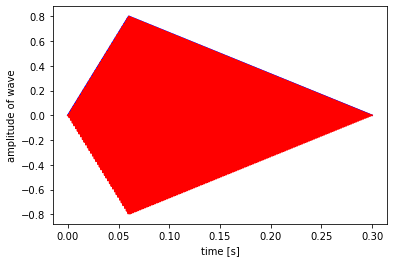

In [8]:
# make the waveform and envelope for one beep. 
# make vectors of two frequencies, that have the same number of points, long enough to hear

dur = 0.3 # in seconds
sr = 44100 # samples/sec
f = 600. # frequency
peak_pos_01 = 0.2 # where the peak of the triangular envelope is
a_scale = 0.8

t,y_osc = make_beep(dur,f,sr)
env = make_env_tri(t,peak_pos_01)
# modulate the signal by multiplication
env = env*a_scale
y = y_osc*env

print(len(y))

# plot the envelope
plt.plot(t,env,'b') 
plt.plot(t,y,'r') 
plt.xlabel('time [s]')
plt.ylabel('amplitude of wave')

In [10]:
ipd.Audio(y, rate=sr) 

# MOTION OF BEEPS ! 
### Zhouyao's code: make some position data.
### (for your project data, you would probably just need to do an interpolation from data to x_position)

Text(2.8, 0.4, '(Right)')

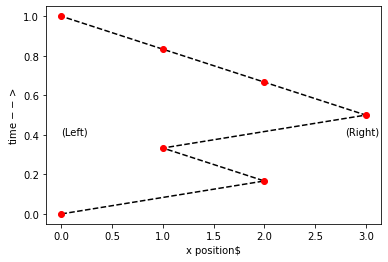

In [19]:
# make up some positions in a range from 0 to 3: 
x_list = [0,2,1,3,2,1,0] 
y_list = np.linspace(0,1,len(x_list))
plt.plot(x_list,y_list,'k--')
plt.plot(x_list,y_list,'ro')
plt.xlabel('x position$')
plt.ylabel('time $-->$')
plt.text(0,0.4,'(Left)')
plt.text(2.8,0.4,'(Right)')

In [20]:
reload(pos_gen)

pos_gen.initialize(0)
pos_gen.move(x_list)
s = pos_gen.s
print(s.shape)
npos = len(s)
print(type(s))

# print(s[:][0])
# print(s.index[-1])
# print(s.loc[s.index[-1]])

# d = s.to_frame(['time','position'])
# print(d.columns)


(162,)
<class 'pandas.core.series.Series'>


In [21]:
# extract the time and position data: 

time = np.ndarray(npos)
posn = np.ndarray(npos)

for i in range(npos):
    time[i] = s.index[i]
    posn[i] = s.loc[s.index[i]]

print(len(time))
dur_track = time[-1]
print('dur_track (total duration of sound) = ', str(dur_track))
# subsample to get beep times ! 
subsam = 3
time_beep = time[0::subsam]
posn_beep = posn[0::subsam]


162
dur_track (total duration of sound) =  16.1


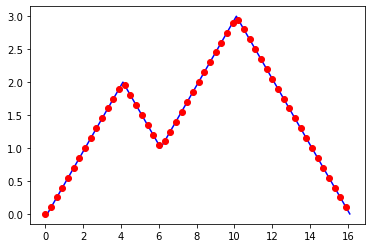

In [22]:
plt.plot(time,posn,'b') 
plt.plot(time_beep,posn_beep,'ro') 

Text(0, 0.5, 'amplitude weights')

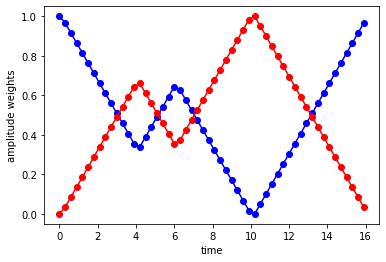

In [52]:
# make the scale factors or weights W for amplitude by position
# stereo version: 
posn_beep = posn_beep/max(posn_beep)

# This is the "perception model":
left_distance = posn_beep 
## linear weights:
W_left = 1 - left_distance 
## non-linear weights:
#W_left = (1 - left_distance)**2 
#W_left = np.sqrt(1-left_distance)

right_distance = 1- posn_beep 
## linear weights:
W_right = 1 - right_distance 
## non-linear weights:
#W_right = (1 - right_distance)**2 
#W_right = np.sqrt(1-right_distance)

#W_left = np.zeros(len(posn_beep))
#W_right = np.zeros(len(posn_beep))

plt.plot(time_beep,W_left,'b-') 
plt.plot(time_beep,W_left,'bo') 
plt.plot(time_beep,W_right,'r-') 
plt.plot(time_beep,W_right,'ro') 
plt.xlabel('time')
plt.ylabel('amplitude weights')


In [53]:
# make the time series of weighted beeps ! 
dt_extra = 1.0 # time to add on to the end for the last beep
n_samp = int((dur_track+dt_extra)*sr)

# make a sounds track of zeros :   (# alternative: concatenate, but that's more complicated) 
time_sound = np.linspace(0,dur_track+dt_extra,n_samp)
channel_left = np.zeros(n_samp) 
channel_right = np.zeros(n_samp) 

print(channel_left.shape)
print(time_sound)

(754110,)
[0.00000000e+00 2.26757670e-05 4.53515341e-05 ... 1.70999546e+01
 1.70999773e+01 1.71000000e+01]


In [54]:
# function to find the location in the time vector of where each beep will be added to the sound

def find_first_t(time_sound, t_bp):
    ind = np.argmax(time_sound>t_bp)
    return ind
       
# or this: 
# bisect_left(alist, value)  
# experiment with this later

In [55]:

for i_samp, t_samp in enumerate(time_beep):
    #print(t_samp)
    # find where in the time_sound each time_beep occurs: 
    i_bp = find_first_t(time_sound, t_samp)
    #print(i_bp)
    
    # make beep
    # for now, nothing is changing with the beep other than the weight determined here, 
    # so we can just use the curve defined above instead of re-calling the functions. 
    # to change pitch or duration or whatnot, the make_beep function would be called here. 
    
    w_l = W_left[i_samp]
    y_w_l = y*w_l
    
    w_r = W_right[i_samp]
    y_w_r = y*w_r
    # add it to the soundtracks (l + r)
    channel_left[i_bp:i_bp+len(y_w_l)] = y_w_l
    channel_right[i_bp:i_bp+len(y_w_r)] = y_w_r

    
#W_right

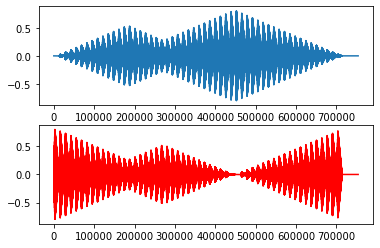

In [56]:
plt.subplot(2,1,1)
plt.plot(channel_right)
plt.subplot(2,1,2)
plt.plot(channel_left, 'r')

In [57]:
# merge into one array to make sound file
# [2,:]
print(len(channel_right))
snd = np.zeros([2,len(channel_right)])
print(snd.shape)
snd[0,:] = channel_left
snd[1,:] = channel_right

ipd.Audio(snd, rate=sr) 

754110
(2, 754110)


## Now adapt for the RTcmix methods: 

In [60]:
import subprocess as sp
from subprocess import Popen
import os
import writeCmixSco_WT_ac as wRT_wt

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

CMIX found.


600.0
test_movingBeep.sco
CMIX found.
rtoutput("test_movingBeep.wav")



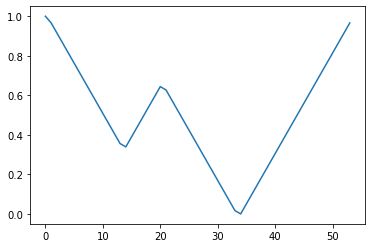

In [67]:
# (2) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_movingBeep'

print(f) # same pitch as above
pitches = f*np.ones(len(time_beep))
dt = dur_track/len(time_beep)
dur_beep = dur # from above

# instead of us calculating the weights, we put in the value for panning:
# "pans"
# which will be the position,interpolated between 0:1 for this stereo track: 
x_posn_range = np.linspace(min(posn_beep),max(posn_beep), 20)
pan_range = np.linspace(0,1,20)
pans = 1-np.interp(posn_beep,x_posn_range,pan_range)

tones_dict = {}
tones_dict['times'] = np.asarray(time_beep)
tones_dict['notes'] = np.asarray(pitches)
tones_dict['durs'] = np.ones(len(pitches))*dt*0.7 # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(pitches))*5000
tones_dict['pans'] = pans

score_name = wRT_wt.writesco(tones_dict,base_name)

plt.plot(pans)

In [68]:
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + base_name + '.sco'
    print(cmix_cmd)
else:
    dur = str(dur_sound)
    cmix_cmd = os.path.abspath('../pyGoRTcmix/pyGoRTcmix') + ' -inputscore ' + os.path.abspath(base_name + '.sco') + ' -output ' + os.path.abspath(base_name + '.wav') + ' -dur ' + dur
    print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
# the ! tells the notebook to run a command in the terminal
if sys.platform == 'win32':
    ! dir *.sco
else:
    ! ls *.sco

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("\n" + "hopefully i just wrote your sound file; is it here?" + "\n")
if sys.platform == 'win32':
    ! dir *.wav
else:
    ! ls *.wav

CMIX < test_movingBeep.sco
L_Temp.sco			test_gotRhythm2.sco
R_Temp.sco			test_GRANSYNTH_v1_pitchjitVAR.sco
test_BAdata_chSweep_Nwts16.sco	test_movingBeep.sco
test_dataChords.sco		test_noRhythm1.sco

hopefully i just wrote your sound file; is it here?

L_Temp.wav  test_BAdata_chSweep_Nwts16.wav  test_GRANSYNTH_v1_pitchjitVAR.wav
R_Temp.wav  test_dataChords.wav		    test_movingBeep.wav
stereo.wav  test_gotRhythm2.wav		    test_noRhythm1.wav
